# 1) Utility functions and general imports

In [1]:
import h5py
import numpy as np
import scipy as scpy
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from scipy import optimize as opt
from sklearn import decomposition
from sklearn import preprocessing

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline


# 2) Creating the functions used throughout the notebook

In [5]:
# Defining utility functions for reading images and data in
def show_image(array, label):
    im = Image.fromarray(array)
    print("Item of label={}".format(label))
    return(imshow(im))
    
def compress_project(percent, data_to_compress):

# Find the principal components that explain 99% of the data
    pca = decomposition.PCA(percent)

    #Run PCA on normalized image data
    lower_dim_data = pca.fit_transform(data_to_compress)    
    print('Shape of lower dimension image {}:'.format(lower_dim_data.shape))

    #Project lower dimension data onto original features
    approximation = pca.inverse_transform(lower_dim_data)
    #approximation = pca.inverse_transform(lower_dim_data)
        
    #Reshape approximation and X_norm to 784*28*28 to display images
    approximation_reshaped = approximation.reshape(-1,784)
    print('Shape of reconstructed image {}:'.format(approximation_reshaped.shape))   
    print( 'Is Original close to Resized? ', np.allclose(data_to_compress, approximation) )
    
    return (approximation, lower_dim_data) 


def shape_matrix_process(split_percent):
    
            
        # Read the source files in
        data, label, test_data, test_label = read_data_in(desktop_or_laptop='d')

        # Creating a fair split of training and validation data for the 
        # training model to be trained on
        indices = range(data.shape[0])
        classes = np.unique(label)
        
        training_records = int(split_percent * data.shape[0])        
        
        # Get the records that are part of the indices declared above
        train_data = data[:training_records]
        validate_data = data[training_records:]        
        
        # Get the labels that are part of the indices declared above
        label_train = label[:training_records]
        label_validate = label[training_records:]        
        
        
        get_class_data = np.vectorize(lambda arr: label==i )
                        
        for i in classes:
            print("Pixel histogram prior to feature scaling : ".format(classes[i]))
            print(i)
        
            d=[]
            d = data[get_class_data(i)]
            h = plt.hist(d[i].ravel())
            plt.show()

        X_train = train_data.reshape(-1, 784)
        X_validate = validate_data.reshape(-1, 784)        
        
        y_train = np.ravel(label_train)
        y_validate = np.ravel(label_validate)    

                
        ##########################################################################  
        # MINMAXSCALER IS THE ONLY SCALER FOUND TO RELIABLY RESULT IN CONVERGENCE*
        # HOWEVER NEEDS FURTHER TESTING =========================================#
        ##########################################################################

        # Fit & transform to our training data set
        X_train = X_train.astype('float32')
        X_train = normalise(X_train)
        
        
        # Change our X_Validate data set to float 32 to 
        
        X_validate = X_validate.astype('float32')
        X_validate = normalise(X_validate)

        print('Total number of records in X train: {}'.format(X_train.shape[0]))
        print('Total number of records in y train: {}'.format(y_train.shape[0]))
        print('Total number of features in X train: {}'.format(X_train.shape[1]))

        print('Total number of records in X train (valdation set): {}'.format(X_validate.shape[0]))
        print('Total number of features in X train (validation set): {}'.format(X_validate.shape[1]))
        
       
        ########################
        # Now to transform test#
        ########################
        
        X_test = test_data[:2000]        
        X_test = test_data.reshape(-1,784)
        y_test = test_label [:2000]       
        X_test = X_test.astype('float32')
            
        ##########################################################################  
        # MINMAXSCALER IS THE ONLY SCALER FOUND TO RELIABLY RESULT IN CONVERGENCE*
        # HOWEVER NEEDS FURTHER TESTING =========================================#
        ##########################################################################

   
        X_test = normalise(X_test)
                                          
        print('Total number of records in X test: {}'.format(X_test.shape[0]))
        print('Total number of features in X test: {}'.format(X_test.shape[1]))
        
        return(X_train,X_validate,X_test,y_train,y_validate,y_test)
    
    
# Import the files in from python h5 format


def read_data_in(desktop_or_laptop='d'):
    
    if desktop_or_laptop == 'l':

        ## Dan's Mac folder location - NEEDS CHANGING
        with h5py.File('../Project1/data/images_training.h5','r') as H:
            data = np.copy(H['data'])
        with h5py.File('../Project1/data/labels_training.h5','r') as H:
            label = np.copy(H['label'])

        with h5py.File('../Project1/data/images_testing.h5','r') as H:
            data_test = np.copy(H['data'])
        with h5py.File('../Project1/data/labels_testing_2000.h5','r') as H:
            label_test = np.copy(H['label'])    


    else:
        ## Dan's desktop folder location - NEEDS CHANGING
        with h5py.File('../../Input/images_training.h5','r') as H:
            data = np.copy(H['data'])
        with h5py.File('../../Input/labels_training.h5','r') as H:
            label = np.copy(H['label'])
        with h5py.File('../../Input/images_testing.h5','r') as H:
            data_test = np.copy(H['data'])

        with h5py.File('../../Input/labels_testing_2000.h5','r') as H:
            label_test = np.copy(H['label'])     
    
    return(data, label, data_test, label_test)

def add_intercept(X_mat,y_mat):
    m = len(y_mat)
    ones = np.ones((m,1))
    
    X = np.concatenate((ones,X_mat),axis=1)
    m,n = X.shape
    print(X.shape)
    return(X,n)

# Is the matrix symmetric?
def is_symmetric(X, tolerance = 1e-9):
    return(np.allclose(X,X.T, atol=tolerance))

def get_minmax(X):
    minmax = list()
    for i in range(len(X[0])):
        column_values = [row[i] for row in X]
        mn = min(column_values)
        mx = max(column_values)
        minmax.append([mn,mx])
    return(minmax)

def normalise(X):
    #print(X_train.shape)
    X_scaled = (X - np.min(X,axis=0)) / (np.max(X, axis=0) - (np.min(X,axis=0) ))
    return(X_scaled)


class LogisticRegression:
    def __init__(self,  max_iter, intercept, k, lmbda ):
        #self.lr = lr
        self.max_iter = max_iter
        self.intercept = intercept
        self.k = k
        self.lmbda = lmbda
        print ("Logistic Regression model initialised with Max iterations = {}, K (classes) = {}, lmbda (Regularisation parameter) ={}".format(self.max_iter,self.k, self.lmbda))
    
    def add_intercept(self, X_mat,y_mat):
        m = len(y_mat)
        ones = np.ones((m,1))

        X_mat = np.concatenate((ones,X_mat),axis=1)
        m_shape,n_shape = X_mat.shape
        #print("n_shape: {}".format(n_shape))
        #print("X_mat.shape: {}".format(X_mat.shape))
        
        return(X_mat,n_shape)
    
    # Defining the sigmoid function required in LR
    def __sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def __cost(self, theta, X_arr, y_arr):
        predictions = self.__sigmoid(X_arr @ theta)
        predictions[predictions == 1] = 0.999 # log(1)=0 causes error in division
        error = -y_arr * np.log(predictions) - (1 - y_arr) * np.log(1 - predictions);
        return sum(error) / len(y_arr);
    
    # Vectorised cost function
    def __costFunctionReg(self,theta, X, y, lmbda):
        m = len(y)
        temp1 = np.multiply(y, np.log(self.__sigmoid(np.dot(X, theta))))
        temp2 = np.multiply(1-y, np.log(1-self.__sigmoid(np.dot(X, theta))))  
        #print(np.sum(temp1 + temp2) / (-m) + np.sum(theta[1:]**2) * lmbda / (2*m))
        return np.sum(temp1 + temp2) / (-m) + np.sum(theta[1:]**2) * lmbda / (2*m)
    
    
    def fit(self, X_mat,max_iter, y_mat,n, full_outp):
                        
        theta = np.zeros((k,n)) #inital parameters
        cost_values = {}
        
        
        print("                                            ")
        print("############################################")
        print("### Gradient Descent Optimisation beginning")
        print("############################################")
        for i in range(k):
            label_class = i if i else 0
            print('Class {} being optimised'.format(i))
            #cost0 = cost(theta, X, (y==label_class.flatten()))
            #cost[i] = cost(theta[i], X,y)
            #print('Cost for Class {}:'.format(cost[i]))               
            #ValueError: cannot copy sequence with size 5 to array axis with dimension 785
            theta[i] = opt.fmin_cg(f = self.__costFunctionReg, x0 = theta[i].flatten(), gtol = 1e-03, fprime = self.__gradient_reg_vectorised, args = (X_mat,(y_mat == label_class).flatten(), self.lmbda),maxiter= max_iter, disp = True, full_output = full_outp)                        
            #cost = {i,}
            #theta[i] = opt.fmin_cg(f = costFunctionReg, x0 = theta[i].flatten(),  fprime = gradRegularization, args = (X_mat,(y == label_class).flatten(), lmbda), maxiter = 200, disp = True)    
            
        print("###########################################")
        print("### Gradient Descent Optimisation finished")
        print("###########################################")
            #if full_outp == 1:
            #    return(theta, fopt, func_calls, grad_calls, warnflag)
            #else:
            #    return(theta)
        return(theta)
    
      
    
    # Vectorised gradient
    def __gradient_reg_vectorised(self, theta, X_arr, y_arr, lmbda):
        m = len(y_arr)
        temp = self.__sigmoid(np.dot(X_arr, theta)) - y_arr
        temp = np.dot(temp.T, X_arr).T / m + theta * lmbda / m
        temp[0] = temp[0] - theta[0] * lmbda / m
        return temp
    
    # Vectorised cost function
    def __cost_func_vectorised(self,theta, X_arr, y_arr, lmbda):
        m = len(y_arr)
        temp_weight1 = np.multiply(y_arr, np.log(self.__sigmoid(np.dot(X_arr, theta))))
        temp_weight2 = np.multiply(1-y_arr, np.log(1-self.__sigmoid(np.dot(X_arr, theta))))
        return np.sum(temp_weight1 + temp_weight2) / (-m) + np.sum(theta[1:]**2) * self.lmbda / (2*m)
    
    
    def predict(self,X,y,theta):    
        preds = []
        preds = np.argmax(X @ theta.T, axis = 1)
        preds = [e if e else 0 for e in preds]
        average_pred = np.mean(preds == y.flatten()) * 100        
        return(preds, average_pred)
        #return(average_pred)
    
    def predict_prob(self,X, theta):
        return (self.__sigmoid(np.dot(X),theta.T))
    
        
    

Pixel histogram prior to feature scaling : 0 


([array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([23.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.]),
  array([21.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  2.,  3.,  0.]),
  array([20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  6.,  1.,  0.,  0.]),
  array([20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  1.,  1.,  3.,  1.,  1.]),
  array([18.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  5.,  1.,  1.,  1.]),
  array([1., 0., 0., 0., 0., 0., 1., 1.,

Pixel histogram prior to feature scaling : 1 


([array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  

Pixel histogram prior to feature scaling : 2 


([array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([12.,  1.,  0.,  1.,  0.,  2.,  0.,  2.,  1.,  0.,  2.,  2.,  3.,
          2.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([4., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 1., 6.,
         3., 7., 2.]),
  array([2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 9.,
         7., 2., 6.]),
  array([1., 0., 1., 0., 1., 0., 0., 2., 2., 0., 2., 1., 0., 0., 1., 2., 2.,
         6., 4., 3.]),
  array([5., 0., 0., 0., 0., 0., 0., 2., 2., 2., 1., 1., 0., 1., 0., 3., 3.,
         3., 2., 3.]),


Pixel histogram prior to feature scaling : 3 


([array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([18.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  1.,  0.,  0.,  1.,
          0.,  1.,  1.,  0.,  0.,  0.,  0.]),
  array([11.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
          2.,  2.,  3.,  2.,  2.,  0.,  3.]),
  array([2., 0., 1., 1., 1., 1., 1., 1.,

Pixel histogram prior to feature scaling : 4 


([array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([15.,  0.,  0.,  2.,  0.,  1.,  1.,  1.,  2.,  2.,  3.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([8., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 6., 4., 5.,
         0., 1., 0.]),
  array([6., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 2., 4., 8., 2., 1.,
         0., 0., 0.]),
  array([5., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 4.,
   

Pixel histogram prior to feature scaling : 5 


([array([26.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([26.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  1.,  0.]),
  array([25.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  1.,  0.]),
  array([25.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  1.,  0.]),
  array([24.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  1.,  0.]),
  array([21.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
          1.,  0.,  0.,  0.,  1.,  0.,  2.]),
  array([20.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,
          0.,  1.,  0.,  1.,  0.,  0.,  3.]),
  array([17.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,
          1.,  1.,  2.,  0.,  1.,  1.,  1.]),
  array([17.,  1.,  0.,  0.,  0.,  0.,  

Pixel histogram prior to feature scaling : 6 


([array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([15.,  1.,  2.,  1.,  2.,  2.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 7.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
          0.,  0., 12.,  4.,  1.,  1.,  0.]),
  array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  6., 12.,  3.,  0.,  0.,  0.]),
  array([1., 0., 0., 1., 1., 0., 1., 1., 2., 3., 0., 0., 2., 0., 5., 6., 5.,
         0., 0., 0.]),
  array([6., 2., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 4., 5., 3.,
         1., 1., 0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0., 10.,  4.,  3.,  1.,  4.,  5.]),
  array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
      

Pixel histogram prior to feature scaling : 7 


([array([24.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  3.,  0.]),
  array([22.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          1.,  0.,  1.,  1.,  0.,  1.,  0.]),
  array([22.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
          0.,  1.,  0.,  0.,  1.,  1.,  0.]),
  array([22.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  1.,  1.,  1.,  0.]),
  array([21.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,
          0.,  0.,  0.,  1.,  1.,  0.,  1.]),
  array([21.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
          0.,  0.,  1.,  0.,  1.,  0.,  1.]),
  array([20.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
          1.,  0.,  1.,  0.,  1.,  0.,  1.]),
  array([20.,  0.,  0.,  0.,  0.,  0.,  

Pixel histogram prior to feature scaling : 8 


([array([25.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([18.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  6.]),
  array([15.,  3.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,
          1.,  0.,  0.,  1.,  0.,  2.,  2.]),
  array([15.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  1.,  4.,  1.,  0.,  0.,  5.]),
  array([5., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 4., 0., 2., 0., 3.,
         3., 3., 4.]),
  array([5., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 3., 3., 1., 3., 1.,
         4., 2., 4.]),
  array([5., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 2., 1., 2., 1.,
         3., 2., 8.]),
  array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,
          0.,  1.,  0.,  4.,  1.,  2., 10.]),
  array([5., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2., 3.,
         2., 2., 7.]),


Pixel histogram prior to feature scaling : 9 


([array([26.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([24.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
          0.,  2.,  0.,  0.,  0.,  0.,  0.]),
  array([23.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
          1.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([22.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
          1.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([22.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
          1.,  0.,  0.,  1.,  0.,  0.,  0.]),
  array([22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,
          0.,  0.,  0.,  2.,  0.,  0.,  0.]),
  array([21.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  0.,
          0.,  1.,  0.,  0.,  0.,  1.,  0.]),
  array([21.,  0.,  0.,  0.,  0.,  0.,  

<function matplotlib.pyplot.tight_layout>

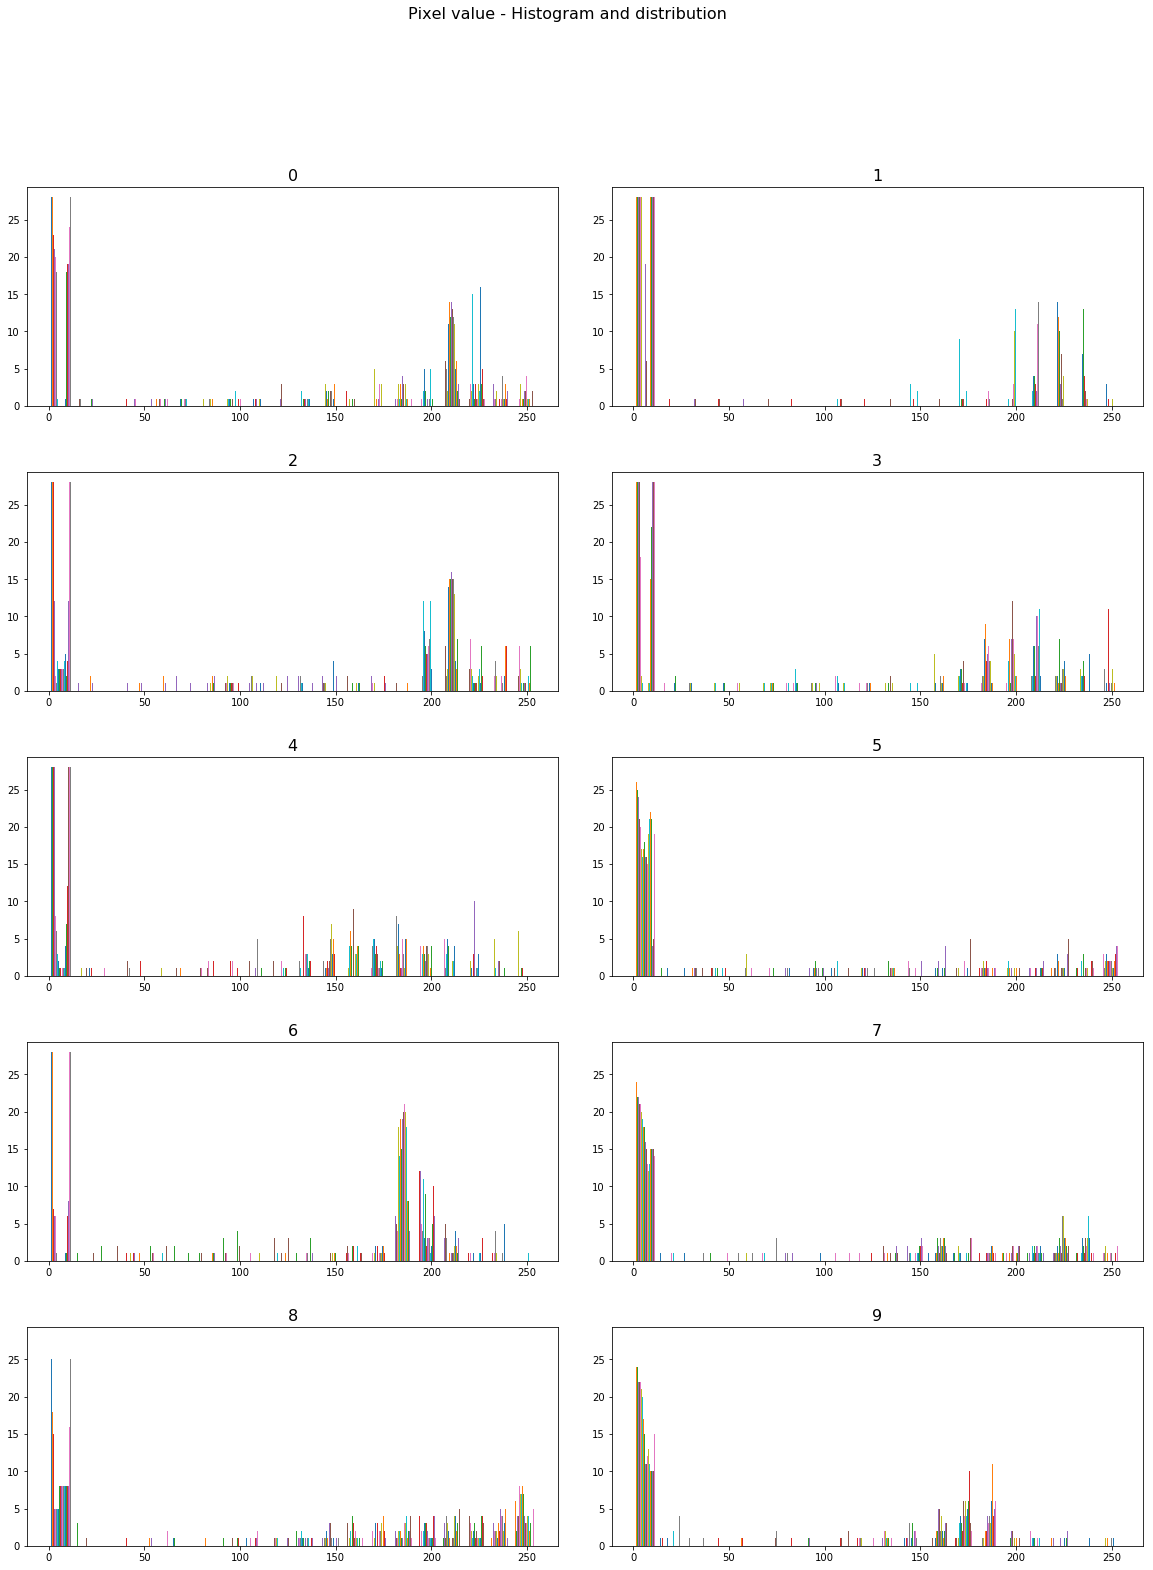

In [72]:
get_class_data = np.vectorize(lambda arr: label==i )

fig, a = plt.subplots(5,2, sharex='row', sharey='col')
fig.set_size_inches(20,25)
fig.subplots_adjust(hspace = 0.3, wspace = 0.1)
fig.suptitle('Pixel value - Histogram and distribution', fontsize = 16)

classes = np.unique(label)
a = a.ravel()
        
for i,ax in enumerate(a):
    print("Pixel histogram prior to feature scaling : {} ".format(classes[i],i))
    #print(i)

    #ax=[]
    d = data[get_class_data(i)]
    ax.hist(d[i], bins = 20)
    ax.set_title(i, fontsize = 16)    
        
    
plt.tight_layout    
plt.savefig("PixelHist_Distiribution.png", dpi = 300)
        
        
        


## For reference: https://github.com/zalandoresearch/fashion-mnist



| Label | Description   |
|------|------|
|   0  | T-shirt/top|
|   1  | Trouser|
|   2  | Pullover|
|   3  | Dress|
|   4  | Coat|
|   5  | Sandal|
|   6  | Shirt|
|   7  | Sneaker|
|   8  | Bag|
|   9  | Ankle boot|

In [ ]:
############IGNORE########################################################
############IGNORE########################################################
############IGNORE########################################################

data, label, data_test, label_test = read_data_in(desktop_or_laptop='d')

train_data = data[:30000]

X_train = train_data.reshape(-1, 784)


#def is_symmetric(X, tolerance = 1e-9):
#    return(np.allclose(X,X.T, atol=tolerance))


 #= data.reshape[-1,784]
#is_sparse(X_train,X_train.shape[0],X_train.shape[1])
#X.shape
#scpy.sparse.isspmatrix(train_data)

#X_train.shape
#data.reshape[-1,784]
#data[3]

In [ ]:
############IGNORE########################################################
############IGNORE########################################################
############IGNORE########################################################
i = 10
#show_image(data[i],label[i])

#print('Total training data shape : ', data.shape, label.shape)
#data_train = data_train / 255


_, axarr = plt.subplots(10,10,figsize=(10,10))

for i in range(10):
    for j in range(10):
       data[np.random.randint(data.shape[0])] 
       axarr[i,j].axis('off')     


# Time to train and preduct using LogisticRegression - One vs Rest!

Pixel histogram prior to feature scaling : 
0


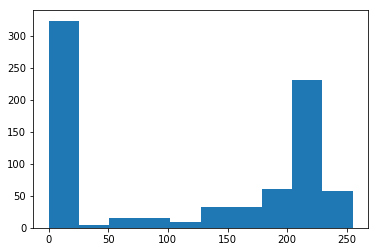

Pixel histogram prior to feature scaling : 
1


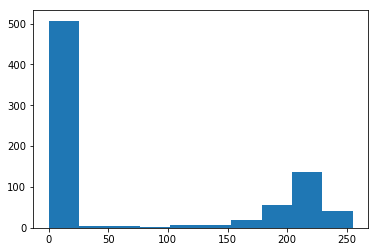

Pixel histogram prior to feature scaling : 
2


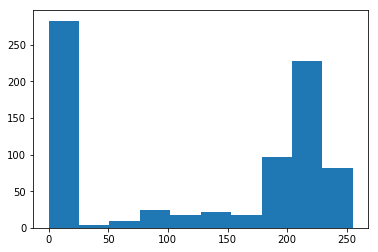

Pixel histogram prior to feature scaling : 
3


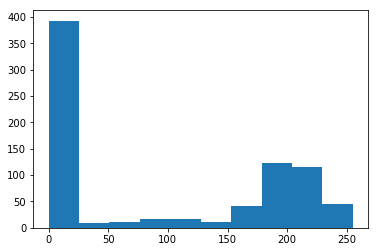

Pixel histogram prior to feature scaling : 
4


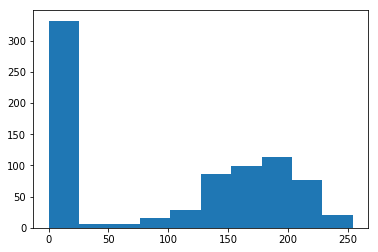

Pixel histogram prior to feature scaling : 
5


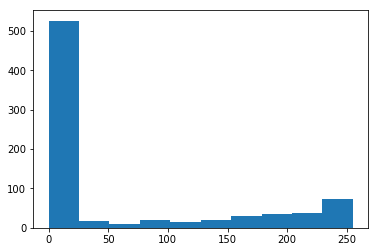

Pixel histogram prior to feature scaling : 
6


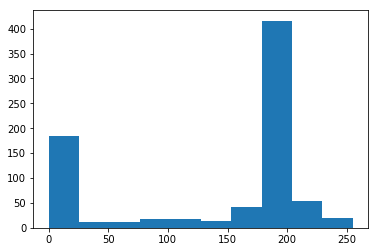

Pixel histogram prior to feature scaling : 
7


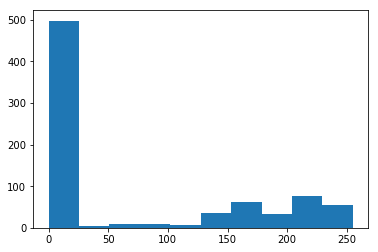

Pixel histogram prior to feature scaling : 
8


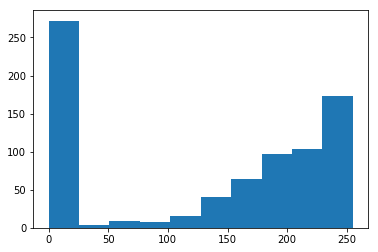

Pixel histogram prior to feature scaling : 
9


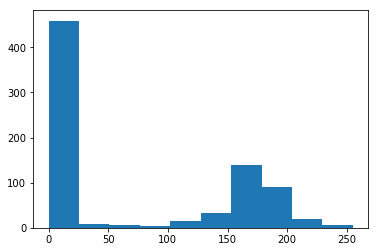

C:\Users\New\Anaconda3\lib\site-packages\ipykernel\__main__.py:171: RuntimeWarning: invalid value encountered in true_divide


Total number of records in X train: 29700
Total number of records in y train: 29700
Total number of features in X train: 784
Total number of records in X train (valdation set): 300
Total number of features in X train (validation set): 784
Total number of records in X test: 5000
Total number of features in X test: 784
#################################################
Logistic Regression model initialised with Max iterations = 500, K (classes) = 10, lmbda (Regularisation parameter) =1
#################################################
                                            
############################################
### Gradient Descent Optimisation beginning
############################################
Class 0 being optimised
Optimization terminated successfully.
         Current function value: 0.101262
         Iterations: 30
         Function evaluations: 65
         Gradient evaluations: 65
Class 1 being optimised
Optimization terminated successfully.
         Current function

In [6]:
%%time

# Hyper-parameter tuning - uncomment the first value if you want to loop
#lambda_values = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
lambda_values = [1]

prediction_average_list = []
prediction_average_test_list = []    

for i in lambda_values:

    # Read the source files in
    # Ben/Stef - You'll need to change this
    data, label, data_test, label_test = read_data_in(desktop_or_laptop='d')

    # Declare variables for instantiation of the LogisticRegression Class
    #lmbda = 2.5
    k = 10
    intercept = True
    max_iter = 500

    # THIS IS A HACK, NOT SURE WHY TEST DATA ISN'T BEING READ IN PROPERLY CURRENTLY
    data_test = data_test[:2000]

    #########################################################################################
    # Once data is read in from file data, we split it for training, validation and testing #
    # standardise, & re-shape it process                                                    #
    #########################################################################################
        
    X_train,X_validate,X_test,y_train,y_validate,y_test = shape_matrix_process(split_percent=0.99)
    X_test = X_test[:2000]


    ############################################
    # Instantiate our logistic Regression model#
    ############################################
    print('#################################################')
    model = LogisticRegression(max_iter, intercept, k, i)
    print('#################################################')

    # Carry out principal component analysis and project back with 99% of variance
    #X_train, X_reduced  = compress_project(percent=.99,data_to_compress=X_train)

    # Add the intercept value
    X_train,n = model.add_intercept(X_train,y_train)

    # Create a theta matrix to capture values of theta when we minimis the objective function below
    theta = np.zeros((k,n)) #inital parameters

    #############################################################################################
    # Using conjugate gradient, we attempt to carry out optimisation to find theta and therefore#
    # Using theta and the data features to predict each class   #################################
    #############################################################################################
    
    # Do you want to see a verbose/full output for conjugate gradient descent?
    
    #theta = model.fit(X_mat=X_train,max_iter=500,y_mat=y_train,n=n, full_outp=False)
    
    
    #theta, fopt, func_calls, grad_calls,warnflag  = model.fit(X_mat=X_train,max_iter=500,y_mat=y_train,n=n, full_outp=False)
    theta  = model.fit(X_mat=X_train,max_iter=500,y_mat=y_train,n=n, full_outp=False)
            
    #######################################################################################
    # Carry out the predictions based on the trained model and then carry out predictions #
    # on the unseen test data                                                             #
    #######################################################################################
    X_test,n = model.add_intercept(X_test,y_test)

    
    preds, prediction_average = model.predict(X=X_train,y=y_train,theta=theta)
    prediction_average_list.append(prediction_average)
    
    
    
    preds_test,prediction_average_test = model.predict(X_test,y_test,theta=theta)    
    prediction_average_test_list.append(prediction_average_test)
    
print("Probability averages on train: ",*prediction_average_list, sep =',')
print("Probability averages on test: ",*prediction_average_test_list, sep =',')

In [ ]:
print(pred_test)
print(y_test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, preds_test)
#cm = metrics.confusion_matrix(y_train, preds)


from sklearn.metrics import classification_report
print(classification_report(y_test, preds_test))

#print(classification_report(y_train, preds_train))


In [35]:
def create_confusion_matrix(actual, preds):
    
  classes = len(np.unique(actual)) # Number of classes 
  
  cm = np.zeros((classes, classes))

  for i in range(len(actual)):
    cm[actual[i]][preds[i]] += 1
    
  return(cm)

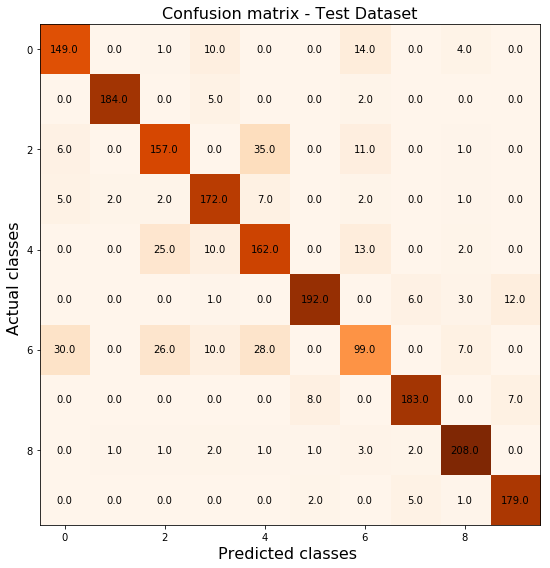

In [39]:

#cm = create_confusion_matrix(y_train, pred_train)
cm = create_confusion_matrix(y_test, pred_test)

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

im = ax.imshow(cm, cmap='Oranges')

# Take the confusion matrix array, and make it pretty with colours and text :)

# A loop to go through every class and plot value for each, with respective colour on the Yellow Green matplotlib colour scale
for i in range(len(np.unique(y_test))):
    for j in range(len(np.unique(y_test))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="k")
#plt.title("Confusion matrix - Train Dataset", fontsize = 16)        
plt.title("Confusion matrix - Test Dataset", fontsize = 16)        

plt.savefig("ConfusionMatrix_Train.png", dpi = 300)
#plt.savefig("ConfusionMatrix_Test.png", dpi = 300)
plt.xlabel("Predicted classes ", fontsize = 16)   
plt.ylabel("Actual classes ", fontsize = 16)   
fig.tight_layout()        

plt.show()

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y.shape